### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error
%matplotlib inline

In [3]:
# Database directory path
database_dir = '/home/Assignment/02_training_pipeline/notebooks/'

 ### 2 Reading Data

In [4]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs


In [5]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

# Function to establish SQLite database connection
def create_sqlite_connection(db_path, db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

# Call function to create database - lead_scoring_model_experimentation.db
create_sqlite_connection(database_dir, r"lead_scoring_model_experimentation.db")

2.6.0


'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:////home/Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="/home/Assignment/mlruns/" --port=6006 --host=0.0.0.0
'''

In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [9]:
# setup pycaret
# PLEASE NOTE : use_gpu=True is crashing in JarvisLabs.ai, hence changed to False value!
Baseline_model_exp01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2023/06/20 16:19:12 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp01' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [10]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7386,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,1.3180
xgboost,Extreme Gradient Boosting,0.7384,0.8211,0.8321,0.7025,0.7618,0.4762,0.4847,9.9100
rf,Random Forest Classifier,0.7373,0.8185,0.8228,0.7044,0.7590,0.4741,0.4811,3.0540
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.9920
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.2400
lr,Logistic Regression,0.7098,0.7836,0.8222,0.6731,0.7402,0.4189,0.4297,2.5160
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.1040
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.4220
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.4700


In [11]:
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5)

In [12]:
# Display model properties
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

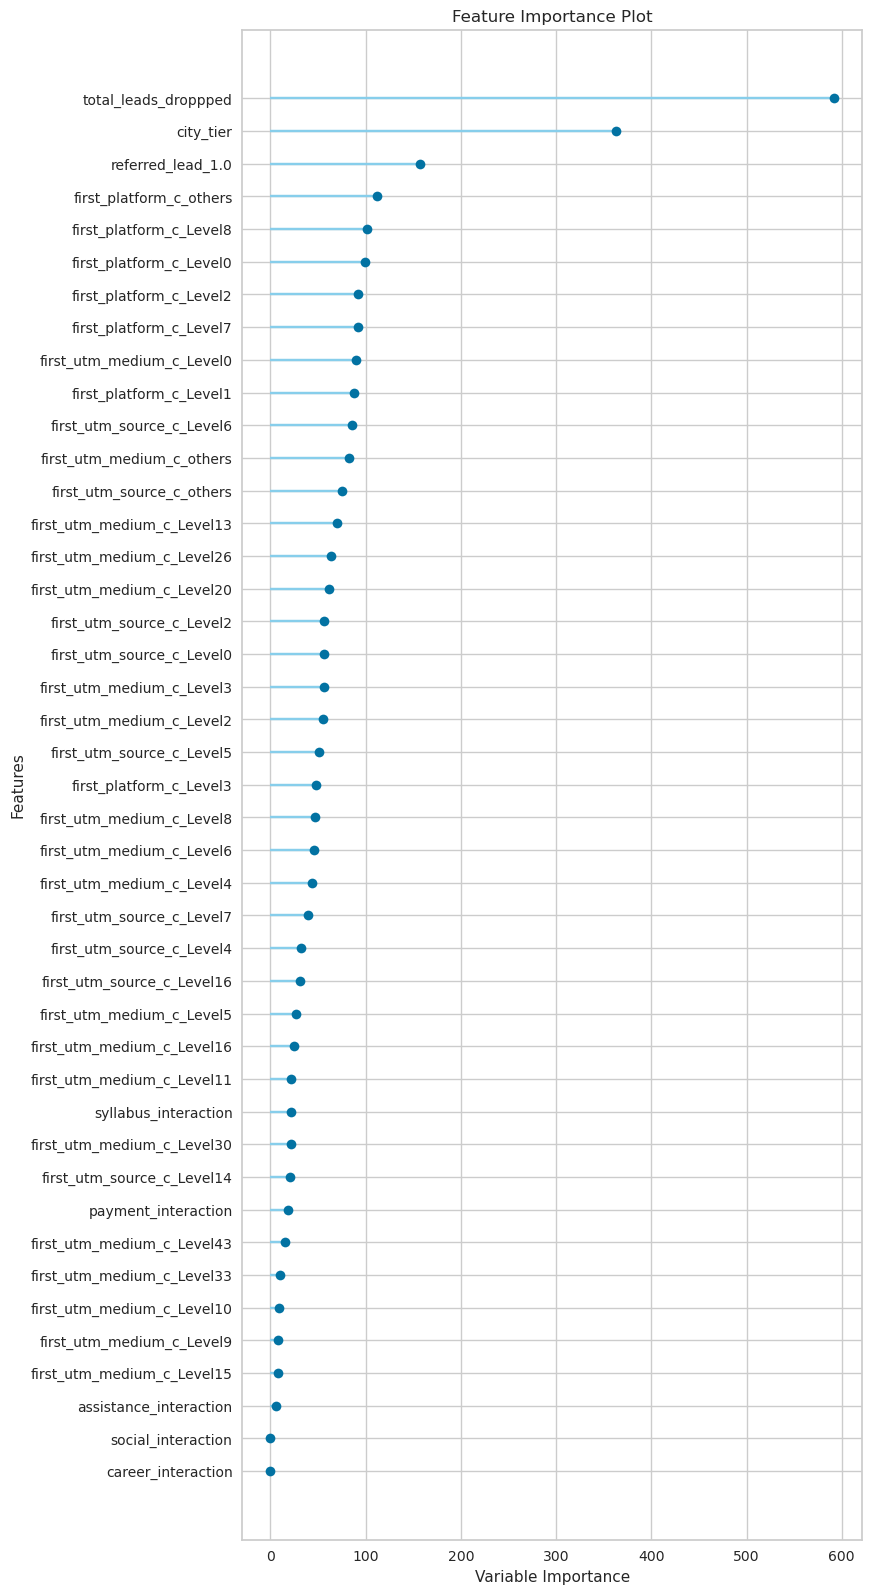

In [13]:
# create feature importance plot
plot_model(lbgm, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [14]:
dataset_dropped = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

In [15]:
# View dataset
dataset_dropped.head()

,total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c,first_utm_medium_c,first_utm_source_c
0,1.0,1.0,0.0,1,Level0,Level11,Level2
1,1.0,2.0,0.0,1,Level3,Level0,others
2,1.0,1.0,0.0,1,Level3,Level0,Level0
3,2.0,1.0,0.0,0,Level1,Level3,others
4,1.0,1.0,0.0,0,Level3,Level0,Level0


In [16]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

# PLEASE NOTE : use_gpu=True is crashing in JarvisLabs.ai, hence changed to False value!
Baseline_model_exp02 = setup(data = dataset_dropped, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='Baseline_model_exp02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False,
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2023/06/20 16:21:31 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp02' does not exist. Creating a new experiment.


In [17]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada'].
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8342,0.7020,0.7624,0.4765,0.4853,1.3480
xgboost,Extreme Gradient Boosting,0.7384,0.8210,0.8320,0.7026,0.7618,0.4763,0.4847,8.6680
rf,Random Forest Classifier,0.7373,0.8184,0.8231,0.7043,0.7591,0.4741,0.4811,2.9100
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.5760
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.1780
lr,Logistic Regression,0.7098,0.7835,0.8220,0.6731,0.7401,0.4188,0.4296,1.0960
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.0900
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.3600
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.0920


In [18]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lbgm  = create_model('lightgbm', fold = 5) 

In [19]:
# Display model properties
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
# Install optuna
!pip install optuna==2.10.1

     |████████████████████████████████| 308 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 16.1 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 56.7 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=26d1dad860409a994dac81a3de19418c3d89a0f28574da52f4a64548ad356d35
  Stored in directory: /home/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [21]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner = tune_model(lbgm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [22]:
# Print the final models configuration so that we can use it in the model retraining pipeline
print(tuner)

OptunaSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         importance_type='split',
                                                         learning_rate=0.1,
                                                         max_depth=-1,
                                                         min_child_sam...
                                    'actual_estimator__reg_alpha': LogUniformDistribution(high=10.0, low=1e-10),
                             

In [23]:
# Display model properties
# We will use this classifier in constants.py!
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


#### Analyzing the model performance

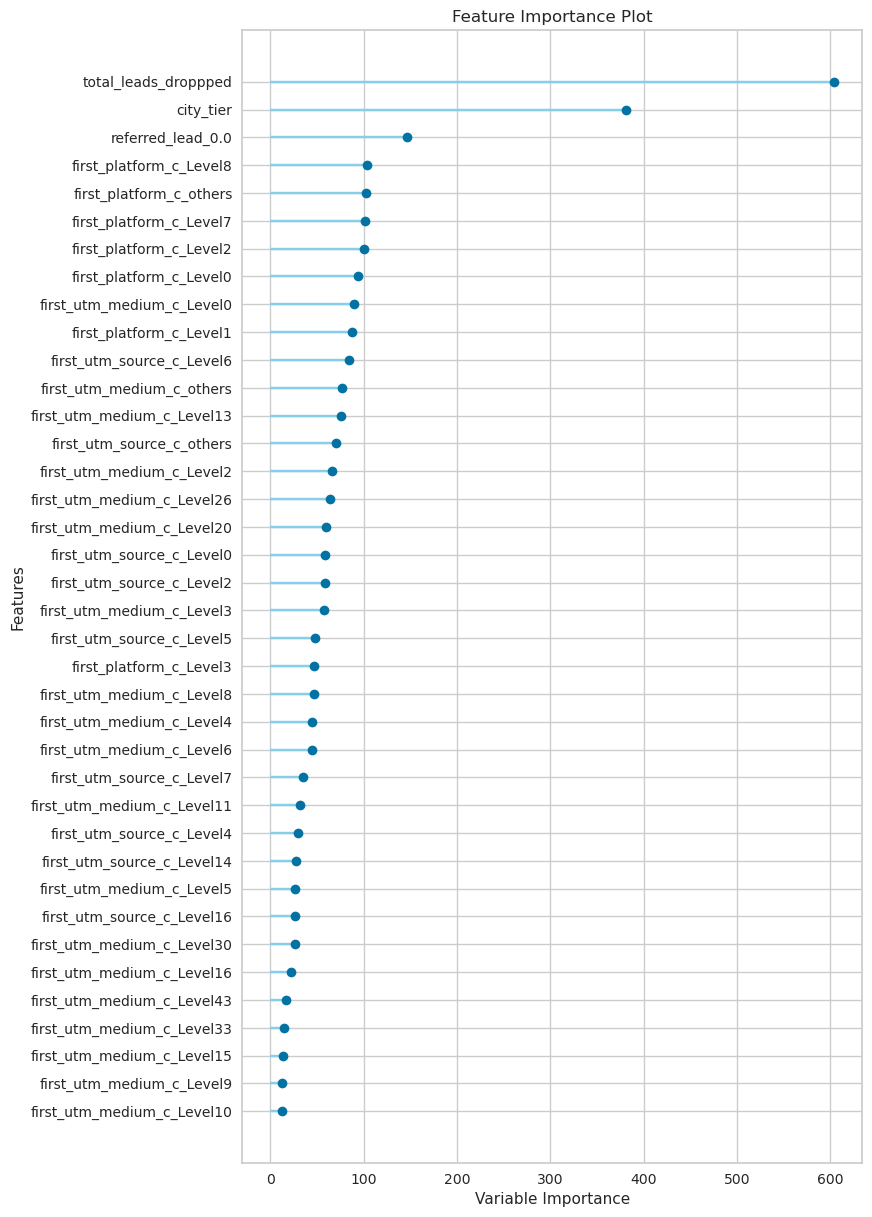

In [24]:
# Create feature importance plot
plot_model(tuned_lgbm_optuna, plot='feature_all')

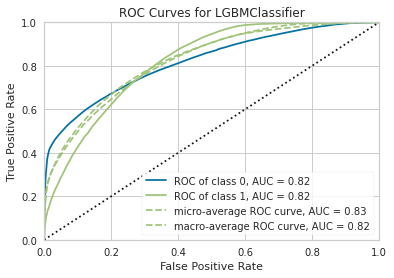

In [25]:
# Create AUC curve plot
plot_model(tuned_lgbm_optuna, plot = 'auc')

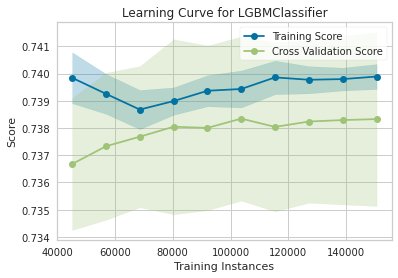

In [26]:
# Learning Curve
plot_model(tuned_lgbm_optuna, plot = 'learning')

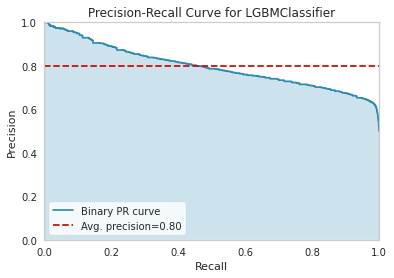

In [27]:
# Precision-recall Curve
plot_model(tuned_lgbm_optuna, plot = 'pr')

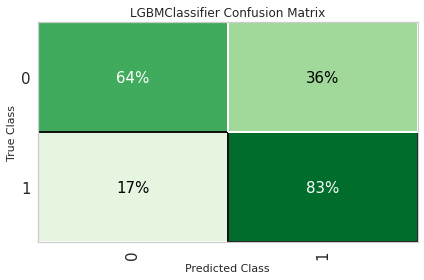

In [28]:
# Confusion Matrix
plot_model(tuned_lgbm_optuna, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

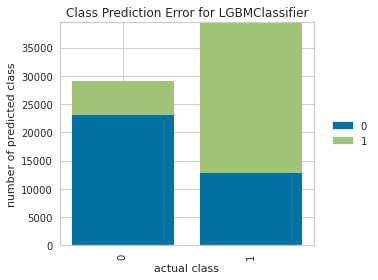

In [29]:
# Prediction class distribution
plot_model(tuned_lgbm_optuna, plot='error')

**Observation**
* Overall our model AUC curve is OK with 0.82
* Learning curve is improving as instances increases
* Precision-recall Curve tells about binary classification accuracy
* Confusion matrix is satisfactory
* Prediction class distribution shows the error rate

#### Model Interpretability

In [31]:
# Install shap
!pip install shap

     |████████████████████████████████| 575 kB 5.9 MB/s eta 0:00:01


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


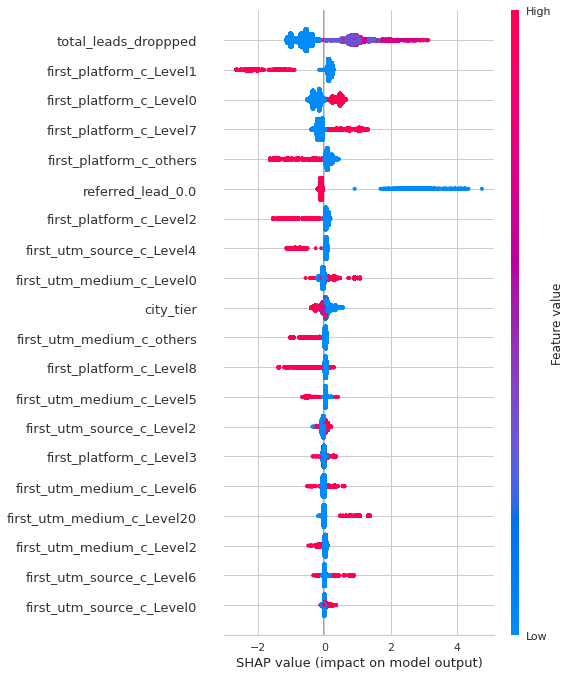

In [32]:
# Interpret model
interpret_model(tuned_lgbm_optuna)

In [33]:
# Index of observation in test data
# Please install Javascript library to view picture
interpret_model(tuned_lgbm_optuna,plot='reason',observation=0)

In [34]:
# Extract feature names
# We will use this list in constants.py!
boost = tuned_lgbm_optuna.booster_
print('Feature names',boost.feature_name())

Feature names ['total_leads_droppped', 'city_tier', 'referred_lead_0.0', 'first_platform_c_Level0', 'first_platform_c_Level1', 'first_platform_c_Level2', 'first_platform_c_Level3', 'first_platform_c_Level7', 'first_platform_c_Level8', 'first_platform_c_others', 'first_utm_medium_c_Level0', 'first_utm_medium_c_Level10', 'first_utm_medium_c_Level11', 'first_utm_medium_c_Level13', 'first_utm_medium_c_Level15', 'first_utm_medium_c_Level16', 'first_utm_medium_c_Level2', 'first_utm_medium_c_Level20', 'first_utm_medium_c_Level26', 'first_utm_medium_c_Level3', 'first_utm_medium_c_Level30', 'first_utm_medium_c_Level33', 'first_utm_medium_c_Level4', 'first_utm_medium_c_Level43', 'first_utm_medium_c_Level5', 'first_utm_medium_c_Level6', 'first_utm_medium_c_Level8', 'first_utm_medium_c_Level9', 'first_utm_medium_c_others', 'first_utm_source_c_Level0', 'first_utm_source_c_Level14', 'first_utm_source_c_Level16', 'first_utm_source_c_Level2', 'first_utm_source_c_Level4', 'first_utm_source_c_Level5', '